## Pivotport, Inc.
#### Allison Lee Summer 2024 Internship Final Project:
#### Comparison of Classical ML and Quantum ML Results in Portfolio Optimization
###### With Rajiv Mistry and Jonathan Ortega

Citation: Citation: Open Source code found at https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html, applied under fair use for learning purposes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Import and Preprocess Data

In [2]:
df = pd.read_csv('Dow_Jones_Data.csv').reset_index(drop=True)
df.head()

# set first column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# drop any rows with ? in them
df = df.drop('Walmart', axis=1)
df = df.drop('DJIA', axis=1)

new_df = df[df.Date < '4/1/2019']
train_df = new_df[new_df.Date < '4/1/2016']
test_df = new_df[new_df.Date >= '4/1/2016']

### Train Data

In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import BaseDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [4]:
# set number of assets (= number of qubits)
num_assets = len(new_df.columns) - 1
seed = 123

tickers = new_df.columns[1:]

start_date = train_df.min().Date
end_date = train_df.max().Date

mu = train_df.iloc[:,1:].mean().tolist()
sig = train_df.iloc[:,1:].cov().values.tolist()

print(mu)
print(sig)

[59.52104278700023, 41.18796586392331, 55.5832546177227, 41.96214168809913, 19.571049801262568, 77.89086509235445, 17.98344166471826, 45.60346738368015, 30.163415608838744, 41.11260696750058, 26.53057049333645, 23.398737432779985, 40.57620528407762, 36.56700023380874, 35.33450783259294]
[[842.710778566224, 430.08055689248016, 833.1262704126308, 534.2938580327597, 188.53857736620387, 639.2777870303275, 56.66912629798253, 501.0400651158717, 256.34676937386695, 648.338625835576, 165.3023985396635, 180.4496900680651, 393.2134819982292, 599.5296417864723, 651.3320625573118], [430.08055689248016, 279.6142168622574, 468.57189214573714, 304.20491361849616, 101.64199151853876, 374.5774426394533, 46.420587965968636, 260.18460990791283, 146.09659312206458, 331.48847038835714, 102.61016675942282, 100.75704965286796, 206.31139253647567, 319.8797431015042, 348.62870358235307], [833.1262704126308, 468.57189214573714, 921.0355007239777, 553.4635311945063, 190.31500177426784, 641.4854817721979, 67.0953

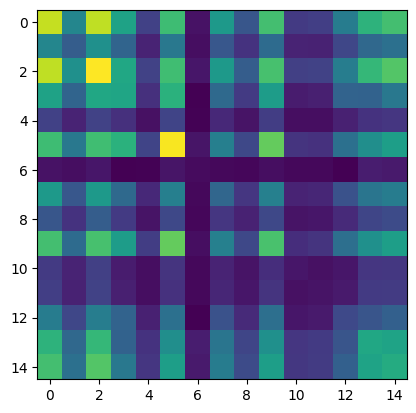

In [5]:
plt.imshow(sig, interpolation="nearest")
plt.show()

In [6]:
q = 0.5  # set risk factor
budget = num_assets // 2 # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sig, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 421.355389283112*x_0^2 + 430.08055689248016*x_0*x_..., 15 variables, 1 constraints, 'Portfolio optimization'>

Print Result Visualization Function

In [7]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.6f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n------------------------------- Full result -----------------------------------")
    print("selection\t\t\t\tvalue\t\t\tprobability")
    print("-------------------------------------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t\t%.4f\t\t%.4f" % (x, value, v))

Classical Machine Learning Result

In [8]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

classical_result = exact_eigensolver.solve(qp)

print_result(classical_result)

Optimal: selection [0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.], value 1735.125536

------------------------------- Full result -----------------------------------
selection				value			probability
-------------------------------------------------------------------------------
[0 1 0 0 1 0 1 0 1 0 1 1 1 0 0]		1735.1255		1.0000


Connect to Azure Quantum Workspace

In [9]:
from os import getenv
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit.primitives import BackendSampler
 
workspace = Workspace.from_connection_string(getenv('AZUREQ_STRING'))
provider = AzureQuantumProvider(workspace)
ionq_sim_backend = provider.get_backend('ionq.simulator')
ionq_sim_backend_sampler = BackendSampler(ionq_sim_backend)

SamplingVQE (Sampling Variational Quantum Eigensolver) Result

In [10]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=ionq_sim_backend_sampler, ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
SVQE_result = svqe.solve(qp)

print_result(SVQE_result)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

QAOA (Quantum Approximate Optimization Algorithm) Result

In [11]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
qaoa_mes = QAOA(sampler=ionq_sim_backend_sampler, optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
QAOA_result = qaoa.solve(qp)

print_result(QAOA_result)

.........................................................................................................................................................................................................................................................................................................................................................................................................................................Optimal: selection [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0.], value 2954.601604

------------------------------- Full result -----------------------------------
selection				value			probability
-------------------------------------------------------------------------------
[1 0 0 1 1 0 1 0 0 1 1 0 0 0 0]		3689.1091		0.0040
[1 1 0 0 0 0 1 0 0 1 0 1 0 0 0]		2781.6012		0.0040
[1 0 1 0 0 1 0 0 0 0 0 0 0 0 1]		5358.4139		0.0040
[0 1 0 0 0 1 0 1 1 1 0 1 0 0 1]		7105.0103		0.0040
[0 1 1 1 1 1 0 0 0 0 0 1 1 1 1]		12588.0950		0.0040
[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]		2061.84

### Testing Data

Classical vs Quantum Portfolio Optimization

Text(0, 0.5, 'Portfolio Value')

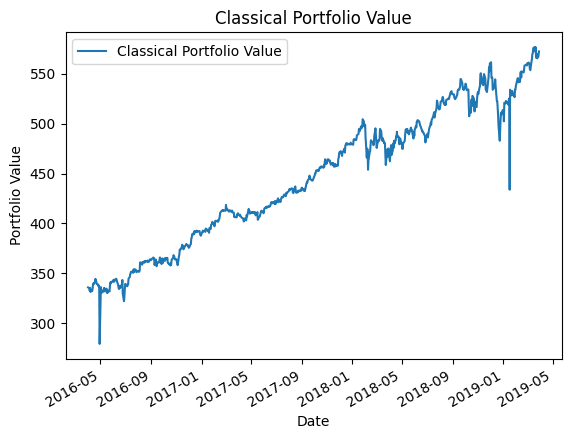

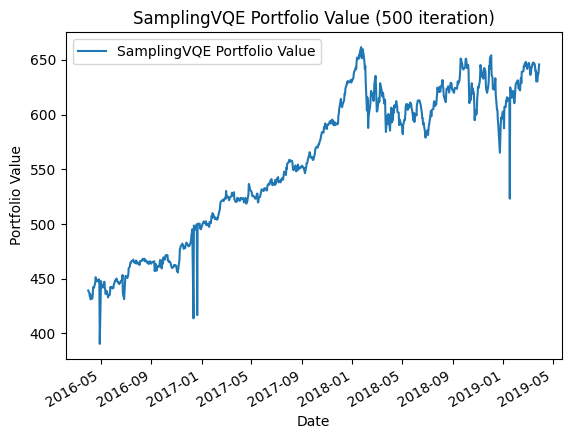

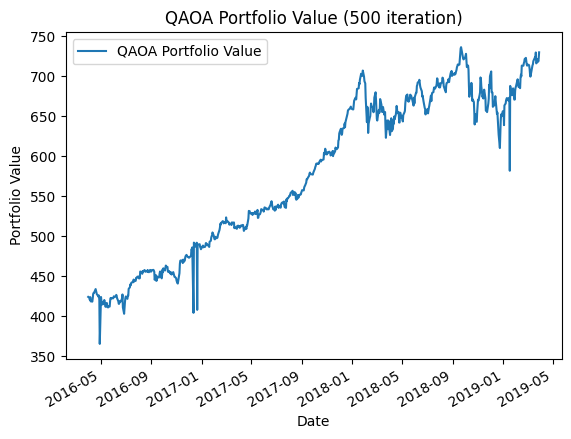

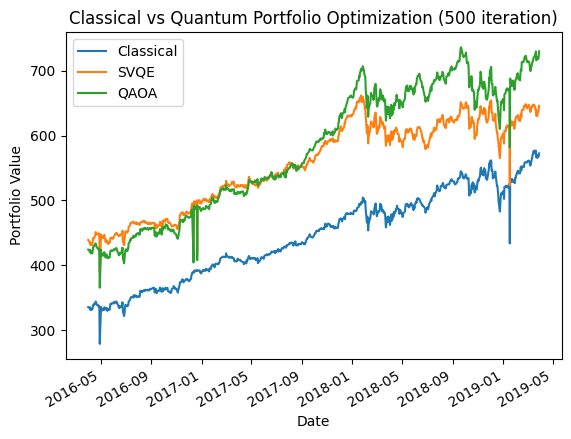

In [12]:
classical_selection = classical_result.x
classical_df = test_df[test_df.columns[1:][classical_selection == 1]]
classical_df = pd.concat([test_df['Date'], classical_df], axis=1)
classical_df['Classical Portfolio Value'] = classical_df.iloc[:,1:].sum(axis=1)
classical_df.plot(x='Date', y='Classical Portfolio Value', title='Classical Portfolio Value')
plt.ylabel('Portfolio Value')

SVQE_selection = SVQE_result.x
SVQE_df = test_df[test_df.columns[1:][SVQE_selection == 1]]
SVQE_df = pd.concat([test_df['Date'], SVQE_df], axis=1)
SVQE_df['SamplingVQE Portfolio Value'] = SVQE_df.iloc[:,1:].sum(axis=1)
SVQE_df.plot(x='Date', y='SamplingVQE Portfolio Value', title='SamplingVQE Portfolio Value (500 iteration)')
plt.ylabel('Portfolio Value')

QAOA_selection = QAOA_result.x
QAOA_df = test_df[test_df.columns[1:][QAOA_selection == 1]]
QAOA_df = pd.concat([test_df['Date'], QAOA_df], axis=1)
QAOA_df['QAOA Portfolio Value'] = QAOA_df.iloc[:,1:].sum(axis=1)
QAOA_df.plot(x='Date', y='QAOA Portfolio Value', title='QAOA Portfolio Value (500 iteration)')
plt.ylabel('Portfolio Value')

overall_df = pd.concat([classical_df['Date'], classical_df['Classical Portfolio Value'], SVQE_df['SamplingVQE Portfolio Value'], QAOA_df['QAOA Portfolio Value']], axis=1)
overall_df.columns = ['Date', 'Classical', 'SVQE', 'QAOA']
overall_df.plot(x='Date', title='Classical vs Quantum Portfolio Optimization (500 iteration)')
plt.ylabel('Portfolio Value')


List of Tickers

In [13]:
classical_tickers = classical_df.columns[1:-1]
SVQE_tickers = SVQE_df.columns[1:-1]
QAOA_tickers = QAOA_df.columns[1:-1]
print("Classical tickers (500 iteration): ", ", ".join(sorted(classical_tickers)))
print("SamplingVQE tickers (500 iteration): ", ", ".join(sorted(SVQE_tickers)))
print("QAOA tickers (500 iteration): ", ", ".join(sorted(QAOA_tickers)))

Classical tickers (500 iteration):  American Express, Coca Cola, Intel, JPMorgan, Merck & Co., Microsoft, Procter & Gamble
SamplingVQE tickers (500 iteration):  Caterpillar, Coca Cola, Intel, J&J, JPMorgan, Procter & Gamble, Walt Disney
QAOA tickers (500 iteration):  Caterpillar, Intel, JPMorgan, Merck & Co., Microsoft, Procter & Gamble, The Home Depot


Cumulative Returns

Text(0, 0.5, 'Cumulative Return')

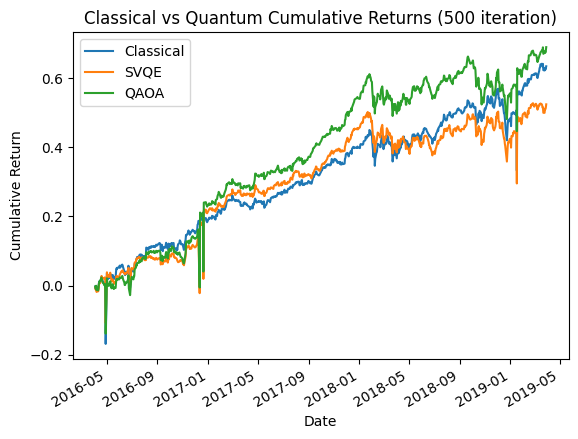

In [14]:
cumulative_returns = pd.DataFrame()
cumulative_returns['Date'] = test_df['Date']
cumulative_returns['Classical'] = classical_df['Classical Portfolio Value'].pct_change().cumsum()
cumulative_returns['SVQE'] = SVQE_df['SamplingVQE Portfolio Value'].pct_change().cumsum()
cumulative_returns['QAOA'] = QAOA_df['QAOA Portfolio Value'].pct_change().cumsum()
cumulative_returns.plot(x='Date', title='Classical vs Quantum Cumulative Returns (500 iteration)')
plt.ylabel('Cumulative Return')